## Polynomial Chaos Expansion Example 3

Author: Katiana Kontolati \
Date: December 8, 2020

In this example, PCE is used to generate a surrogate model for a given set of 2D data.

### Six-hump camel function

<img src="Example_3_function.png" alt="Drawing" style="width: 400px;"/>

$$ f(\textbf{x}) = \Big(4-2.1x_1^2 + \frac{x_1^4}{3} \Big)x_1^2 + x_1x_2 + (-4 + 4x_2^2)x_2^2$$

**Description:**  Dimensions: 2

**Input Domain:**  This function is evaluated on the hypercube $x_1 \in [-3, 3], x_2 \in [-2, 2]$.

**Global minimum:** $f(\textbf{x}^*)=-1.0316,$ at $\textbf{x}^* = (0.0898, -0.7126)$ and $(-0.0898, 0.7126)$.

**Reference:**  Molga, M., & Smutnicki, C. Test functions for optimization needs (2005). Retrieved June 2013, from http://www.zsd.ict.pwr.wroc.pl/files/docs/functions.pdf.

Import necessary libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from UQpy.Surrogates import *

Define the function.

In [2]:
def function(x,y):
    return (4-2.1*x**2 + x**4/3)*x**2 + x*y + (-4+4*y**2)*y**2

Create a distribution object, generate samples and evaluate the function at the samples.

In [3]:
np.random.seed(1)

dist_1 = Uniform(loc=-2, scale=4)    
dist_2 = Uniform(loc=-1, scale=2)    

marg = [dist_1, dist_2]
joint = JointInd(marginals=marg)

n_samples = 250
x = joint.rvs(n_samples)
y = function(x[:,0], x[:,1])  

Visualize the 2D function.

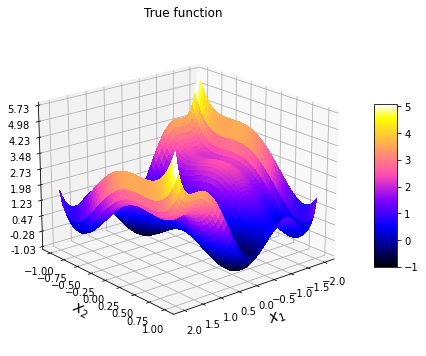

In [4]:
xmin, xmax = -2,2
ymin, ymax = -1,1
X1 = np.linspace(xmin, xmax, 50)
X2 = np.linspace(ymin, ymax, 50)
X1_, X2_ = np.meshgrid(X1, X2) # grid of points
f = function(X1_, X2_)

fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X1_, X2_, f, rstride=1, cstride=1, cmap='gnuplot2', linewidth=0, antialiased=False)
ax.set_title('True function')
ax.set_xlabel('$x_1$', fontsize=15)
ax.set_ylabel('$x_2$', fontsize=15)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.view_init(20, 50)
fig.colorbar(surf, shrink=0.5, aspect=7)

plt.show()

Visualize training data.

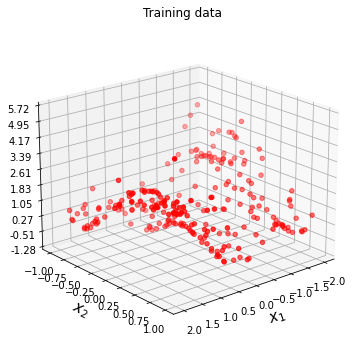

In [5]:
fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')
ax.scatter(x[:,0], x[:,1], y, s=20, c='r')

ax.set_title('Training data')
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.view_init(20,50)
ax.set_xlabel('$x_1$', fontsize=15)
ax.set_ylabel('$x_2$', fontsize=15)
#ax.set_xlim(-10,10)
#ax.set_ylim(-6,6)
#ax.set_zlim(-1,1.5)
plt.show()

Create an object from the PCE class.

In [6]:
max_degree = 6
polys = Polynomials(dist_object=joint, degree=max_degree) 

Compute PCE coefficients using least squares regression.

In [7]:
lstsq = PolyChaosLstsq(poly_object=polys)
pce = PCE(method=lstsq) 
pce.fit(x,y) 

Compute PCE coefficients using LASSO.

In [8]:
lasso = PolyChaosLasso(poly_object=polys, learning_rate=0.1, iterations=1000, penalty=0.1)
pce2 = PCE(method=lasso) 
pce2.fit(x,y) 

Compute PCE coefficients with Ridge regression.

In [9]:
ridge = PolyChaosRidge(poly_object=polys, learning_rate=0.01, iterations=1000, penalty=0.1)
pce3 = PCE(method=ridge) 
pce3.fit(x,y)

PCE surrogate is used to predict the behavior of the function at new samples.

In [10]:
n_test_samples = 20000
x_test = joint.rvs(n_test_samples)
y_test = pce.predict(x_test)

Plot PCE prediction.

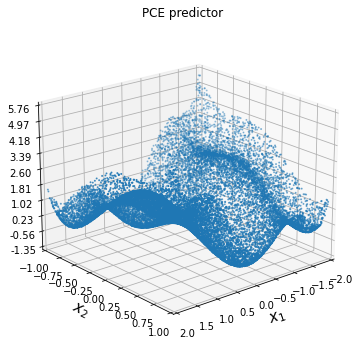

In [11]:
fig = plt.figure(figsize=(10,6))
ax = fig.gca(projection='3d')
ax.scatter(x_test[:,0], x_test[:,1], y_test, s=1)

ax.set_title('PCE predictor')
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.view_init(20,50)
ax.set_xlim(-2,2)
ax.set_ylim(-1,1)
ax.set_xlabel('$x_1$', fontsize=15)
ax.set_ylabel('$x_2$', fontsize=15)
#ax.set_zlim(0,136)
plt.show()

### Error Estimation

Validation error.

In [12]:
n_samples = 150
x_val = joint.rvs(n_samples)
y_val = function(x_val[:,0], x_val[:,1])

error = ErrorEstimation(surr_object=pce)
error2 = ErrorEstimation(surr_object=pce2)
error3 = ErrorEstimation(surr_object=pce3)

print('Error from least squares regression is: ', error.validation(x_val, y_val))
print('Error from LASSO regression is: ', error2.validation(x_val, y_val))
print('Error from Ridge regression is: ', error3.validation(x_val, y_val))

Error from least squares regression is:  0.0
Error from LASSO regression is:  3e-07
Error from Ridge regression is:  4e-07


### Moment Estimation

Returns mean and variance of the PCE surrogate.

In [13]:
n_mc = 1000000
x_mc = joint.rvs(n_mc)
y_mc = function(x_mc[:,0], x_mc[:,1])    
mu = np.mean(y_mc)

print('Moments from least squares regression :', MomentEstimation(surr_object=pce).get())
print('Moments from LASSO regression :', MomentEstimation(surr_object=pce2).get())
print('Moments from Ridge regression :', MomentEstimation(surr_object=pce3).get())
print('Moments from Monte Carlo integration: ', (round((1/n_mc)*np.sum(y_mc),6), round((1/n_mc)*np.sum((y_mc-mu)**2),6)))

Moments from least squares regression : (1.127619, 1.380713)
Moments from LASSO regression : (1.127542, 1.380272)
Moments from Ridge regression : (1.12751, 1.379393)
Moments from Monte Carlo integration:  (1.127527, 1.380522)
